# 双稳态基因调控网络模拟

本 notebook 实现了一个 **互相抑制的 toggle switch 模型**，展示：
- **(a)** 互相抑制模型的数学定义
- **(b)** A/B 随时间变化的轨迹
- **(c)** A-B 状态空间散点，用颜色表示时间


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 设置更好看的绘图风格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


## 1) 模型定义：互相抑制的 toggle switch

数学模型：
$$\frac{dA}{dt} = \alpha_A \cdot \text{repress}(B) - \delta_A \cdot A$$
$$\frac{dB}{dt} = \alpha_B \cdot \text{repress}(A) - \delta_B \cdot B$$

其中 Hill 抑制函数为：
$$\text{repress}(x) = \frac{1}{1 + (x/K)^n}$$


In [2]:
def hill_repress(x, K=20.0, n=4.0):
    """Hill 抑制函数：x 越大，输出越接近 0"""
    return 1.0 / (1.0 + (x / K) ** n)


def simulate_toggle(
    T=5.0, dt=1e-3,
    alphaA=60.0, alphaB=60.0,
    deltaA=1.0, deltaB=1.0,
    K=20.0, n=4.0,
    A0=5.0, B0=40.0,
    noise=0.0,
    alphaA_schedule=None
):
    """
    模拟 toggle switch 动力学
    
    dA/dt = alphaA * repress(B) - deltaA * A
    dB/dt = alphaB * repress(A) - deltaB * B
    
    Parameters:
    -----------
    noise: 简单高斯噪声强度（教学用）
    alphaA_schedule: 如果传入函数 alphaA_schedule(t)，则 alphaA 随时间变化
    """
    steps = int(T / dt) + 1
    t = np.linspace(0, T, steps)
    A = np.zeros(steps)
    B = np.zeros(steps)
    A[0], B[0] = A0, B0
    
    for i in range(steps - 1):
        aA = alphaA_schedule(t[i]) if alphaA_schedule else alphaA
        aB = alphaB
        
        dA = aA * hill_repress(B[i], K, n) - deltaA * A[i]
        dB = aB * hill_repress(A[i], K, n) - deltaB * B[i]
        
        # 教学用噪声项（不是严格的化学主方程/Gillespie）
        if noise > 0:
            dA += noise * np.random.randn()
            dB += noise * np.random.randn()
        
        A[i + 1] = max(0.0, A[i] + dt * dA)
        B[i + 1] = max(0.0, B[i] + dt * dB)
    
    return t, A, B


In [6]:
print("=" * 50)
print("最终稳态结果：")
print("=" * 50)
print(f"初值 (40, 5)  → 终态: A = {A1[-1]:.2f}, B = {B1[-1]:.2f}")
print(f"初值 (5, 40)  → 终态: A = {A2[-1]:.2f}, B = {B2[-1]:.2f}")
print(f"初值 (10, 10.1) → 终态: A = {A3[-1]:.2f}, B = {B3[-1]:.2f}")
print(f"初值 (10.1, 10) → 终态: A = {A4[-1]:.2f}, B = {B4[-1]:.2f}")
print("\n→ 可以看到：微小的初值差异导致完全不同的命运！")


最终稳态结果：
初值 (40, 5)  → 终态: A = 59.86, B = 0.80
初值 (5, 40)  → 终态: A = 0.80, B = 59.86
初值 (10, 10.1) → 终态: A = 4.84, B = 52.64
初值 (10.1, 10) → 终态: A = 52.64, B = 4.84

→ 可以看到：微小的初值差异导致完全不同的命运！


## 3) 分岔过程演示

让 αA 随时间缓慢上升，模拟"参数漂移导致的命运转变"


## 4) 可选：加噪声，更像"随机分子轨迹"


---

## 总结

通过这个 notebook，我们展示了：

1. **双稳态现象**：相同参数、不同初值 → 收敛到不同稳态
2. **分岔过程**：参数随时间变化会导致系统"命运转变"
3. **噪声效应**：添加噪声让轨迹更接近真实的随机分子动力学

### 下一步

如果想要更严格的随机模拟，可以实现 **Gillespie SSA** 算法。


---

## 6) Gillespie SSA：精确随机模拟

前面的 ODE 模拟是**确定性**的，产生光滑曲线。而论文中 Figure 1.3(b) 使用的是 **Gillespie 算法**（Stochastic Simulation Algorithm），它：

- 把分子数建模为**离散整数**
- 每个反应（产生/降解）是独立的**随机事件**
- 反应之间的等待时间服从**指数分布**
- 精确采样自 **Chemical Master Equation (CME)**

这会产生内禀的随机涨落，更接近真实的分子动力学。
- Gillespie 不是ODE + noise，本质区别：Gillespie 模拟的是一个 跳跃过程（Jump Process），不是连续微分！
- CME 告诉你：在 t 时刻，这 1000 个宇宙中有多少比例处于状态 (a,b)
$$P(\text{A}=102, \text{B}=99 \text{ at } t=0.1) = ?$$
- CME 是一组巨大的 ODE，追踪每一个可能状态的概率。
- CME: CTMC 的 Kolmogorov 前向方程
- Gillespie : CTMC 的 精确模拟算法


### 好问题：

问题1："分子数越少，噪声越大"的理论和代码体现\
理论：泊松噪声，在 SSA 中，分子数服从泊松分布，\
相对噪声（CV） = 标准差/平均值 = √N / N = 1/√N 
$$\text{CV} = \frac{\sigma}{\mu} = \frac{\sqrt{N}}{N} = \frac{1}{\sqrt{N}}$$


 
 问题2：SSA 的 G vs ODE 的 G

 |            | SSA                                      | ODE                                 |
 |------------|------------------------------------------|-------------------------------------|
 | G 代表     | 分子数（molecule count）                 | 浓度（concentration）                      | 
 | 数据类型   | 离散整数（0, 1, 2, 3...）            | 连续实数（1.234...）                |
 | 变化方式   | 每次 ±1                                      | 连续变化 dG/dt                            |
 | 单位       | 个（molecules）                         | mol/L 或 nM 等                       |
 



问题3：对比代码（SSA + ODE）

| Row | 模型 | 稳态分子数 | 相对噪声 CV | 行为             |
|-----|------|------------|-------------|------------------|
| 1   | SSA  | ~5         | ~45%        | 频繁跳跃         |
| 2   | SSA  | ~50        | ~14%        | 偶尔跳跃/更稳定  |
| 3   | ODE  | ∞ (连续)   | 0%          | 完全稳定，无跳跃 |

这个对比清楚地展示了：分子数 → ∞ 时，SSA → ODE！




问题4：ODE vs SSA 在双稳态系统中的行为

| 特性             | ODE（确定性）           | SSA（随机）                  |
|------------------|------------------------|------------------------------|
| 最终态取决于      | 100% 初始条件           | 初始条件 + 随机噪声           |
| 轨迹             | 唯一确定                | 每次运行都不同                |
| 能否跨越势垒      | ❌ 不能                 | ✅ 可以（噪声驱动）            |

**具体解释：**

- ODE 描述的是理想情况下分子数无穷大，噪声为零的平均行为，系统轨迹唯一，由初始条件100%决定，永远不会自己“跳”到另一稳态。
- SSA（如 Gillespie 算法）在分子数有限时自动引入本征噪声，因此同样的初始条件每次模拟也可能走不同的轨迹，甚至可能被噪声推着跨越势垒，实现状态切换（noise-induced transitions）。


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 设置更好看的绘图风格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12



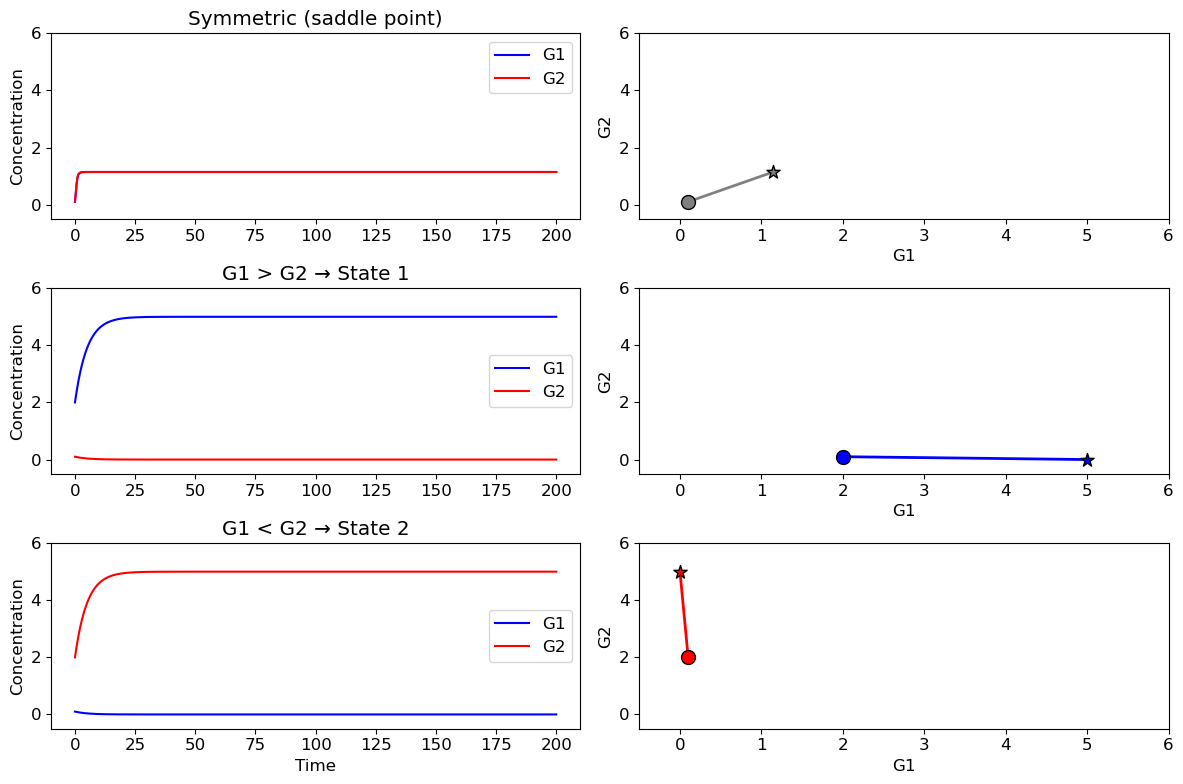

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

k_1 = 1
gamma_1 = 0.2
k_2 = 1
gamma_2 = 0.2
c = 1
h = 9

def toggle_switch_ode(y, t, k_1, k_2, gamma_1, gamma_2, c, h):
    G1, G2 = y
    dG1_dt = k_1 * (c**h / (c**h + G2**h)) - gamma_1 * G1
    dG2_dt = k_2 * (c**h / (c**h + G1**h)) - gamma_2 * G2
    return [dG1_dt, dG2_dt]

t = np.linspace(0, 200, 2000)

# 三种不同的初始条件
initial_conditions = [
    ([0.1, 0.1], 'Symmetric (saddle point)', 'gray'),
    ([2.0, 0.1], 'G1 > G2 → State 1', 'blue'),
    ([0.1, 2.0], 'G1 < G2 → State 2', 'red'),
]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for i, (y0, title, color) in enumerate(initial_conditions):
    solution = odeint(toggle_switch_ode, y0, t, args=(k_1, k_2, gamma_1, gamma_2, c, h))
    
    axes[i, 0].plot(t, solution[:, 0], color='blue', label='G1')
    axes[i, 0].plot(t, solution[:, 1], color='red', label='G2')
    axes[i, 0].set_ylabel('Concentration')
    axes[i, 0].set_title(f'{title}')
    axes[i, 0].legend()
    axes[i, 0].set_ylim(-0.5, 6)
    
    # 相图轨迹
    axes[i, 1].plot(solution[:, 0], solution[:, 1], color=color, linewidth=2)
    axes[i, 1].scatter(y0[0], y0[1], s=100, c=color, marker='o', edgecolors='black', zorder=5)
    axes[i, 1].scatter(solution[-1, 0], solution[-1, 1], s=100, c=color, marker='*', edgecolors='black', zorder=5)
    axes[i, 1].set_xlabel('G1')
    axes[i, 1].set_ylabel('G2')
    axes[i, 1].set_xlim(-0.5, 6)
    axes[i, 1].set_ylim(-0.5, 6)

axes[2, 0].set_xlabel('Time')
plt.tight_layout()
plt.show()

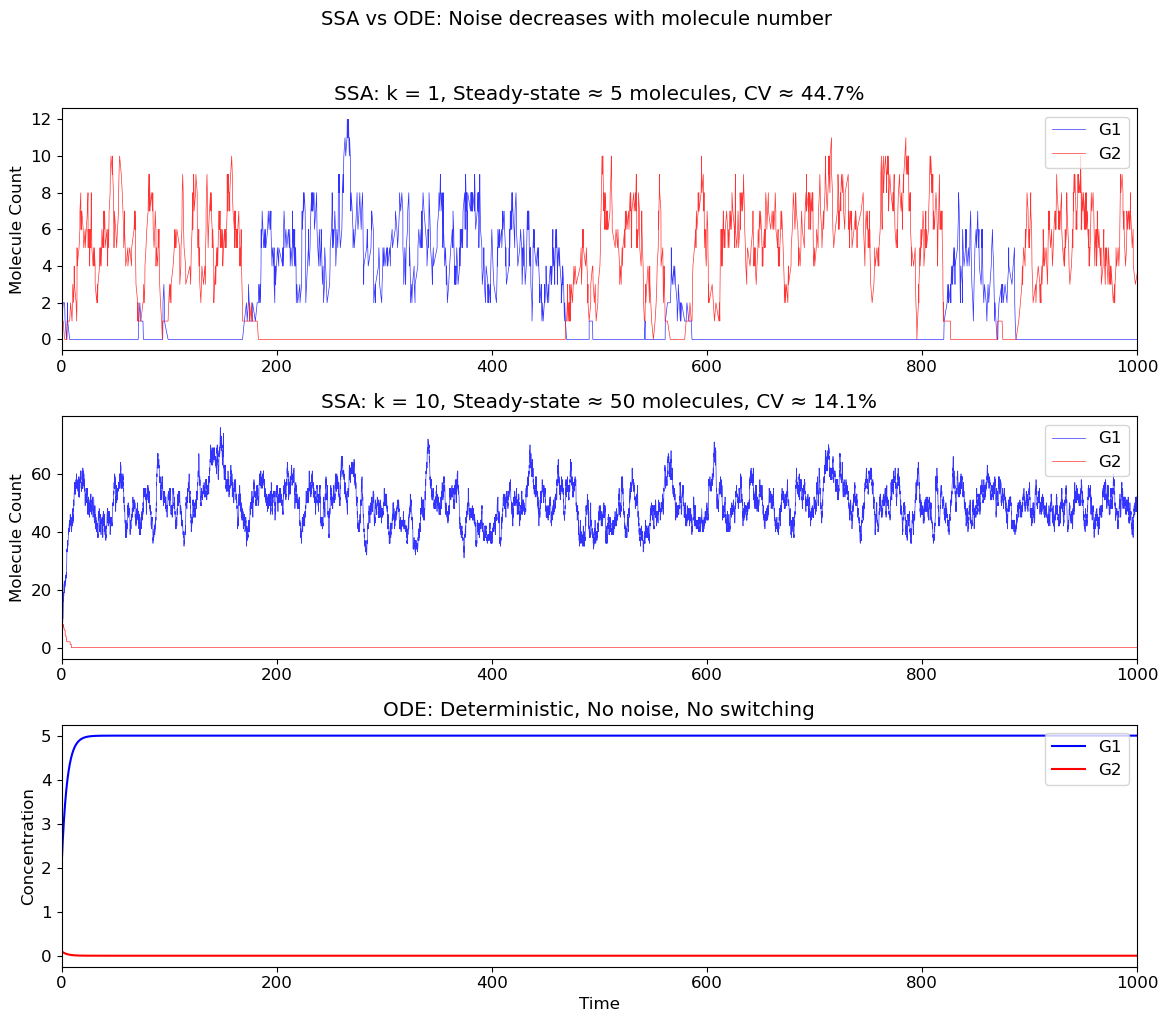

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint

# ODE 模型定义
def toggle_switch_ode(y, t, k_1, k_2, gamma_1, gamma_2, c, h):
    G1, G2 = y
    dG1_dt = k_1 * (c**h / (c**h + G2**h)) - gamma_1 * G1
    dG2_dt = k_2 * (c**h / (c**h + G1**h)) - gamma_2 * G2
    return [dG1_dt, dG2_dt]

# 比较不同的分子数量级
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# ============ Row 1 & 2: SSA with different molecule numbers ============
for idx, k_scale in enumerate([1, 10]):
    
    G1 = [0] # 初始条件 G1=0, G2=0（对称）
    G2 = [0]
    t = [0]
    
    tend = 1000
    k_1 = 1 * k_scale
    gamma_1 = 0.2
    k_2 = 1 * k_scale
    gamma_2 = 0.2
    c = 1 * k_scale
    h = 9
    
    while t[-1] < tend:
        props = [(c**h / (c**h + G2[-1]**h)) * k_1, gamma_1 * G1[-1],
                 (c**h / (c**h + G1[-1]**h)) * k_2, gamma_2 * G2[-1]]
        prop_sum = sum(props)
        if prop_sum == 0:
            prop_sum = 0.001
        tau = np.random.exponential(scale=1/prop_sum)
        t.append(t[-1] + tau)
        rand = random.uniform(0, 1)
        
        if rand * prop_sum <= props[0]:
            G1.append(G1[-1] + 1)
            G2.append(G2[-1])
        elif rand * prop_sum <= sum(props[:2]):
            G1.append(G1[-1] - 1)
            G2.append(G2[-1])
        elif rand * prop_sum <= sum(props[:3]):
            G1.append(G1[-1])
            G2.append(G2[-1] + 1)
        else:
            G1.append(G1[-1])
            G2.append(G2[-1] - 1)
    
    # G1 和 G2 画在同一个 panel
    axes[idx].plot(t, G1, 'b-', linewidth=0.5, label='G1', alpha=0.8)
    axes[idx].plot(t, G2, 'r-', linewidth=0.5, label='G2', alpha=0.8)
    axes[idx].set_ylabel('Molecule Count')
    axes[idx].set_title(f'SSA: k = {k_scale}, Steady-state ≈ {5*k_scale} molecules, CV ≈ {1/np.sqrt(5*k_scale)*100:.1f}%')
    axes[idx].legend(loc='upper right')
    axes[idx].set_xlim(0, tend)

# ============ Row 3: ODE ============
k_1 = 1
gamma_1 = 0.2
k_2 = 1
gamma_2 = 0.2
c = 1
h = 9

t_ode = np.linspace(0, 1000, 10000)
y0 = [2.0, 0.1]  # 非对称初始条件，避免卡在鞍点 

solution = odeint(toggle_switch_ode, y0, t_ode, args=(k_1, k_2, gamma_1, gamma_2, c, h))

axes[2].plot(t_ode, solution[:, 0], 'b-', linewidth=1.5, label='G1')
axes[2].plot(t_ode, solution[:, 1], 'r-', linewidth=1.5, label='G2')
axes[2].set_ylabel('Concentration')
axes[2].set_xlabel('Time')
axes[2].set_title('ODE: Deterministic, No noise, No switching')
axes[2].legend(loc='upper right')
axes[2].set_xlim(0, 1000)

plt.suptitle('SSA vs ODE: Noise decreases with molecule number', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [92]:
# 和前面完全等价！ 只是写法不同：


def gillespie_toggle_switch(
    T_max=100,
    alpha_A=300.0, alpha_B=300.0,
    delta_A=1.0, delta_B=1.0,
    K=150.0, n=4.0,
    A0=100, B0=100
):
    """
    Gillespie SSA for mutual repression toggle switch.
    
    Reactions:
    1. ∅ → A  (production of A, repressed by B)
    2. A → ∅  (degradation of A)
    3. ∅ → B  (production of B, repressed by A)
    4. B → ∅  (degradation of B)
    
    Parameters:
    -----------
    T_max : float
        Maximum simulation time
    alpha_A, alpha_B : float
        Maximum production rates
    delta_A, delta_B : float
        Degradation rates
    K : float
        Hill function threshold
    n : float
        Hill coefficient
    A0, B0 : int
        Initial molecule counts
    """
    
    def hill_repress(x, K, n):
        return 1.0 / (1.0 + (x / K) ** n)
    
    # Initial state
    A, B = A0, B0
    t = 0.0
    
    # Record trajectory
    times = [t]
    A_traj = [A]
    B_traj = [B]
    
    while t < T_max:
        # Calculate propensities (reaction rates)
        a1 = alpha_A * hill_repress(B, K, n)  # A production
        a2 = delta_A * A                       # A degradation
        a3 = alpha_B * hill_repress(A, K, n)  # B production
        a4 = delta_B * B                       # B degradation
        
        a_total = a1 + a2 + a3 + a4
        
        if a_total == 0:
            break
        
        # 步骤1: 下一个事件什么时候发生？
        # Time to next reaction (exponential distribution) 
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        
        if t > T_max:
            break
        
        
        # 步骤2: 发生哪个反应？
        # Which reaction fires? (proportional to propensity)
        r = np.random.random() * a_total
        
        if r < a1:
            A += 1              # A produced
        elif r < a1 + a2:
            A = max(0, A - 1)   # A degraded
        elif r < a1 + a2 + a3:
            B += 1              # B produced
        else:
            B = max(0, B - 1)   # B degraded
        
        # Record state
        times.append(t)
        A_traj.append(A)
        B_traj.append(B)
    
    return np.array(times), np.array(A_traj), np.array(B_traj)

print("Gillespie SSA 函数已定义 ✓")


Gillespie SSA 函数已定义 ✓


In [216]:
# 运行 Gillespie SSA 模拟
#
# 关键参数和上一版本对应关系（这个名字更好）：
# alpha = k      (最大产生率)
# delta = gamma  (降解率)
# K = c          (Hill 函数的"开关阈值")
# n = h          (Hill 系数)
#
# 稳态分子数：A ≈ alpha_A / delta_A
#            B ≈ alpha_B / delta_B


np.random.seed(42) 

alpha_A = 350
delta_A = 1.0

alpha_B = 350        # 和 A 完全对称
delta_B = 1.0

K = 160              # ⭐ 约为稳态的一半
n = 4.1              # ⭐ 较小，让竞争更激烈、转变更慢 
# =====================================

t_ssa, A_ssa, B_ssa = gillespie_toggle_switch(
    T_max=2.0,
    alpha_A=alpha_A, alpha_B=alpha_B,
    delta_A=delta_A, delta_B=delta_B,
    K=K, n=n,
    A0=100, B0=100
)

print(f"模拟完成：共 {len(t_ssa)} 个反应事件")
print(f"最终状态：A = {A_ssa[-1]}, B = {B_ssa[-1]}")
print(f"A 稳态 ≈ {alpha_A/delta_A:.1f}, B 稳态 ≈ {alpha_B/delta_B:.1f}")



模拟完成：共 1400 个反应事件
最终状态：A = 157, B = 150
A 稳态 ≈ 350.0, B 稳态 ≈ 350.0


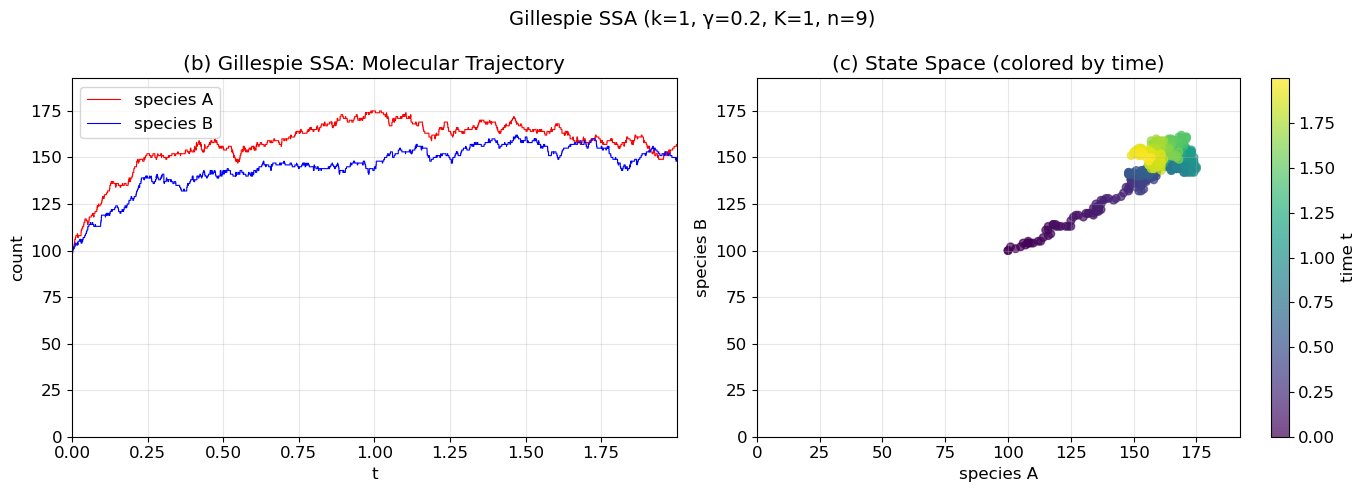

In [217]:
# 绘制 Gillespie SSA 结果 - 适配低分子数参数
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (b) 时间轨迹 - 使用阶梯图展示离散跳跃
ax1 = axes[0]
ax1.step(t_ssa, A_ssa, 'r-', where='post', linewidth=0.8, label='species A')
ax1.step(t_ssa, B_ssa, 'b-', where='post', linewidth=0.8, label='species B')
ax1.set_xlabel('t')
ax1.set_ylabel('count')
ax1.set_title('(b) Gillespie SSA: Molecular Trajectory')
ax1.legend()
ax1.set_xlim(0, t_ssa[-1])  # 自动适配模拟时间
ax1.set_ylim(0, max(max(A_ssa), max(B_ssa)) * 1.1)  # 自动适配分子数
ax1.grid(alpha=0.3)

# (c) 状态空间散点，颜色表示时间
ax2 = axes[1]
# 均匀采样一些点用于散点图
sample_idx = np.linspace(0, len(t_ssa)-1, min(500, len(t_ssa))).astype(int)
sc = ax2.scatter(A_ssa[sample_idx], B_ssa[sample_idx], c=t_ssa[sample_idx], 
                  s=30, cmap='viridis', alpha=0.7)
ax2.set_xlabel('species A')
ax2.set_ylabel('species B')
ax2.set_title('(c) State Space (colored by time)')
plt.colorbar(sc, ax=ax2, label='time t')
max_val = max(max(A_ssa), max(B_ssa)) * 1.1
ax2.set_xlim(0, max_val)  # 自动适配
ax2.set_ylim(0, max_val)  # 自动适配
ax2.grid(alpha=0.3)

plt.suptitle('Gillespie SSA (k=1, γ=0.2, K=1, n=9)', fontsize=14)
plt.tight_layout()
plt.show()

In [218]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 创建控件
w_alpha = widgets.FloatSlider(value=350, min=100, max=500, step=10, description='alpha:')
w_K = widgets.FloatSlider(value=160, min=50, max=300, step=10, description='K:')
w_n = widgets.FloatSlider(value=4.0, min=1, max=10, step=0.5, description='n:')
w_T = widgets.FloatSlider(value=1.0, min=0.5, max=5, step=0.5, description='T_max:')
w_A0 = widgets.IntSlider(value=100, min=0, max=300, step=10, description='A0:')
w_B0 = widgets.IntSlider(value=100, min=0, max=300, step=10, description='B0:')
w_seed = widgets.Checkbox(value=False, description='固定随机种子')

run_button = widgets.Button(description='▶ 运行模拟', button_style='success')
output = widgets.Output()

def run_simulation(b):
    with output:
        clear_output(wait=True)
        
        if w_seed.value:
            np.random.seed(42)
        
        t_ssa, A_ssa, B_ssa = gillespie_toggle_switch(
            T_max=w_T.value,
            alpha_A=w_alpha.value, alpha_B=w_alpha.value,
            delta_A=1.0, delta_B=1.0,
            K=w_K.value, n=w_n.value,
            A0=w_A0.value, B0=w_B0.value
        )
        
        # 绘图
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].step(t_ssa, A_ssa, 'r-', where='post', lw=0.8, label='A')
        axes[0].step(t_ssa, B_ssa, 'b-', where='post', lw=0.8, label='B')
        axes[0].set_xlabel('t'); axes[0].set_ylabel('count')
        axes[0].legend(); axes[0].grid(alpha=0.3)
        axes[0].set_title(f'最终: A={A_ssa[-1]}, B={B_ssa[-1]}')
        
        sample_idx = np.linspace(0, len(t_ssa)-1, min(300, len(t_ssa))).astype(int)
        sc = axes[1].scatter(A_ssa[sample_idx], B_ssa[sample_idx], 
                             c=t_ssa[sample_idx], s=20, cmap='viridis', alpha=0.7)
        axes[1].set_xlabel('A'); axes[1].set_ylabel('B')
        plt.colorbar(sc, ax=axes[1], label='t')
        axes[1].grid(alpha=0.3)
        
        plt.suptitle(f'α={w_alpha.value}, K={w_K.value}, n={w_n.value}')
        plt.tight_layout()
        plt.show()

run_button.on_click(run_simulation)

# 显示控件
controls = widgets.VBox([
    widgets.HBox([w_alpha, w_K, w_n]),
    widgets.HBox([w_T, w_A0, w_B0, w_seed]),
    run_button
])
display(controls, output)

Output()

# 加入自激活

In [230]:
# 加入自激活

def gillespie_toggle_switch_with_selfloop(
    T_max=1.0,
    alpha_A=300.0, alpha_B=300.0,
    delta_A=1.0, delta_B=1.0,
    K_rep=150.0,      # 互相抑制的阈值
    K_act=100.0,      # 自激活的阈值
    n_rep=4.0,        # 抑制 Hill 系数
    n_act=2.0,        # 激活 Hill 系数
    A0=100, B0=100
):
    """
    带自激活的 toggle switch
    
    Production rate = alpha * hill_activate(self) * hill_repress(other)
    """
    
    def hill_repress(x, K, n):
        return 1.0 / (1.0 + (x / K) ** n)
    
    def hill_activate(x, K, n):
        return (x / K) ** n / (1.0 + (x / K) ** n)
    
    A, B = A0, B0
    t = 0.0
    times, A_traj, B_traj = [t], [A], [B]
    
    while t < T_max:
        # A 的产生：被 B 抑制，被自己激活
        a1 = alpha_A * (0.1 + 0.9 * hill_activate(A, K_act, n_act)) * hill_repress(B, K_rep, n_rep)
        a2 = delta_A * A
        
        # B 的产生：被 A 抑制，被自己激活
        a3 = alpha_B * (0.1 + 0.9 * hill_activate(B, K_act, n_act)) * hill_repress(A, K_rep, n_rep)
        a4 = delta_B * B
        
        a_total = a1 + a2 + a3 + a4
        if a_total == 0:
            break
            
        tau = np.random.exponential(1.0 / a_total)
        t += tau
        if t > T_max:
            break
        
        r = np.random.random() * a_total
        if r < a1:
            A += 1
        elif r < a1 + a2:
            A = max(0, A - 1)
        elif r < a1 + a2 + a3:
            B += 1
        else:
            B = max(0, B - 1)
        
        times.append(t)
        A_traj.append(A)
        B_traj.append(B)
    
    return np.array(times), np.array(A_traj), np.array(B_traj)

In [231]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 创建控件 - 新增自激活参数
w_alpha = widgets.FloatSlider(value=250, min=100, max=500, step=10, description='alpha:')
w_K_rep = widgets.FloatSlider(value=150, min=50, max=300, step=10, description='K_rep:')
w_K_act = widgets.FloatSlider(value=100, min=20, max=200, step=10, description='K_act:')
w_n_rep = widgets.FloatSlider(value=2.0, min=1, max=10, step=0.5, description='n_rep:')
w_n_act = widgets.FloatSlider(value=2.0, min=1, max=6, step=0.5, description='n_act:')
w_T = widgets.FloatSlider(value=5.0, min=0.5, max=5, step=0.5, description='T_max:')
w_A0 = widgets.IntSlider(value=100, min=0, max=300, step=10, description='A0:')
w_B0 = widgets.IntSlider(value=100, min=0, max=300, step=10, description='B0:')
w_seed = widgets.Checkbox(value=False, description='固定随机种子')

run_button = widgets.Button(description='▶ 运行模拟', button_style='success')
output = widgets.Output()

def run_simulation(b):
    with output:
        clear_output(wait=True)
        
        if w_seed.value:
            np.random.seed(42)
        
        t_ssa, A_ssa, B_ssa = gillespie_toggle_switch_with_selfloop(
            T_max=w_T.value,
            alpha_A=w_alpha.value, alpha_B=w_alpha.value,
            delta_A=1.0, delta_B=1.0,
            K_rep=w_K_rep.value, K_act=w_K_act.value,
            n_rep=w_n_rep.value, n_act=w_n_act.value,
            A0=w_A0.value, B0=w_B0.value
        )
        
        # 绘图
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].step(t_ssa, A_ssa, 'r-', where='post', lw=0.8, label='A')
        axes[0].step(t_ssa, B_ssa, 'b-', where='post', lw=0.8, label='B')
        axes[0].set_xlabel('t'); axes[0].set_ylabel('count')
        axes[0].legend(); axes[0].grid(alpha=0.3)
        axes[0].set_title(f'最终: A={A_ssa[-1]}, B={B_ssa[-1]}')
        
        sample_idx = np.linspace(0, len(t_ssa)-1, min(300, len(t_ssa))).astype(int)
        sc = axes[1].scatter(A_ssa[sample_idx], B_ssa[sample_idx], 
                             c=t_ssa[sample_idx], s=20, cmap='viridis', alpha=0.7)
        axes[1].set_xlabel('A'); axes[1].set_ylabel('B')
        plt.colorbar(sc, ax=axes[1], label='t')
        axes[1].grid(alpha=0.3)
        
        plt.suptitle(f'α={w_alpha.value}, K_rep={w_K_rep.value}, K_act={w_K_act.value}, n_rep={w_n_rep.value}, n_act={w_n_act.value}')
        plt.tight_layout()
        plt.show()

run_button.on_click(run_simulation)

# 显示控件 - 分组更清晰
controls = widgets.VBox([
    widgets.HTML('<b>产生率 & 抑制参数：</b>'),
    widgets.HBox([w_alpha, w_K_rep, w_n_rep]),
    widgets.HTML('<b>自激活参数：</b>'),
    widgets.HBox([w_K_act, w_n_act]),
    widgets.HTML('<b>模拟设置：</b>'),
    widgets.HBox([w_T, w_A0, w_B0, w_seed]),
    run_button
])
display(controls, output)

Output()

# 多轨迹采样 - 复现 Figure 1.3(c)

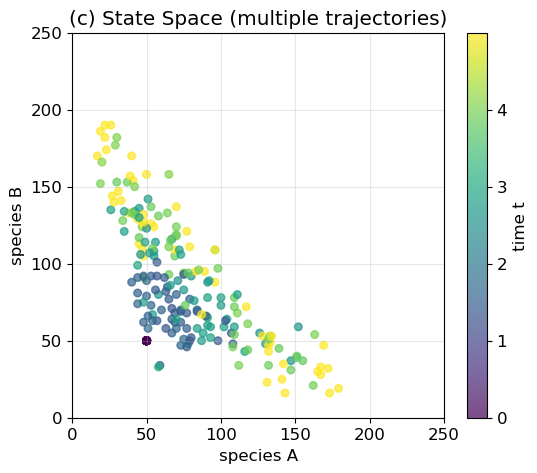

In [352]:

n_trajectories = 50  # 运行50次模拟
all_A, all_B, all_t = [], [], []

for _ in range(n_trajectories):
    t_ssa, A_ssa, B_ssa = gillespie_toggle_switch_with_selfloop(
        T_max=5.0,
        alpha_A=250, alpha_B=250,
        K_rep=150, K_act=100,
        n_rep=2, n_act=2,
        A0=50, B0=50
    )
    # 每条轨迹采样几个点
    sample_idx = np.linspace(0, len(t_ssa)-1, 5).astype(int)
    all_A.extend(A_ssa[sample_idx])
    all_B.extend(B_ssa[sample_idx])
    all_t.extend(t_ssa[sample_idx])

# 绘图
plt.figure(figsize=(6, 5))
sc = plt.scatter(all_A, all_B, c=all_t, s=30, cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='time t')
plt.xlabel('species A')
plt.ylabel('species B')
plt.title('(c) State Space (multiple trajectories)')
plt.grid(alpha=0.3)
plt.xlim(0, 250)
plt.ylim(0, 250)
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# 控件
w_alpha = widgets.FloatSlider(value=260, min=100, max=500, step=10, description='alpha:')
w_K_rep = widgets.FloatSlider(value=170, min=50, max=300, step=10, description='K_rep:')
w_K_act = widgets.FloatSlider(value=50, min=20, max=200, step=10, description='K_act:')
w_n_rep = widgets.FloatSlider(value=7.0, min=1, max=10, step=0.5, description='n_rep:')
w_n_act = widgets.FloatSlider(value=2.5, min=1, max=6, step=0.5, description='n_act:')
w_T = widgets.FloatSlider(value=2.5, min=0.5, max=10, step=0.5, description='T_max:')
w_A0 = widgets.IntSlider(value=100, min=0, max=200, step=10, description='A0/B0:')
w_n_traj = widgets.IntSlider(value=50, min=10, max=100, step=10, description='轨迹数:')

run_button = widgets.Button(description='▶ 运行', button_style='success')
output = widgets.Output()

def run_sim(b):
    with output:
        clear_output(wait=True)
        all_A, all_B, all_t = [], [], []
        
        for _ in range(w_n_traj.value):
            t_ssa, A_ssa, B_ssa = gillespie_toggle_switch_with_selfloop(
                T_max=w_T.value,
                alpha_A=w_alpha.value, alpha_B=w_alpha.value,
                K_rep=w_K_rep.value, K_act=w_K_act.value,
                n_rep=w_n_rep.value, n_act=w_n_act.value,
                A0=w_A0.value, B0=w_A0.value
            )
            sample_idx = np.linspace(0, len(t_ssa)-1, 10).astype(int)
            all_A.extend(A_ssa[sample_idx])
            all_B.extend(B_ssa[sample_idx])
            all_t.extend(t_ssa[sample_idx])
        
        plt.figure(figsize=(6, 5))
        sc = plt.scatter(all_A, all_B, c=all_t, s=30, cmap='viridis', alpha=0.7)
        plt.colorbar(sc, label='time t')
        plt.xlabel('species A')
        plt.ylabel('species B')
        plt.title(f'State Space ({w_n_traj.value} trajectories)')
        plt.grid(alpha=0.3)
        plt.xlim(0, w_alpha.value * 1.2)
        plt.ylim(0, w_alpha.value * 1.2)
        plt.show()

run_button.on_click(run_sim)

display(widgets.VBox([
    widgets.HBox([w_alpha, w_K_rep, w_K_act]),
    widgets.HBox([w_n_rep, w_n_act, w_T]),
    widgets.HBox([w_A0, w_n_traj]),
    run_button
]), output)





Output()

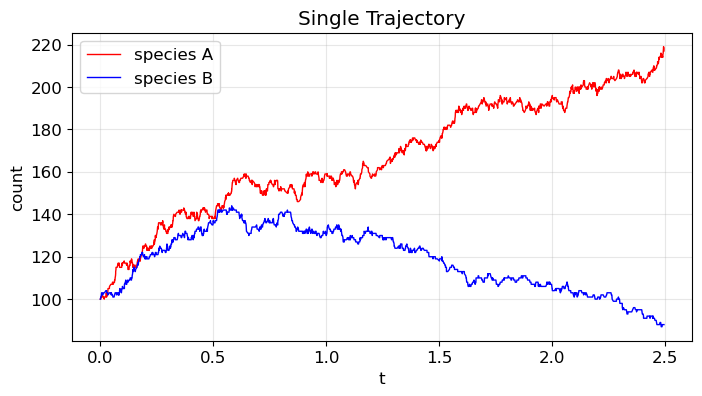

In [354]:
# 单轨迹可视化
t_ssa, A_ssa, B_ssa = gillespie_toggle_switch_with_selfloop(
    T_max=w_T.value,
    alpha_A=w_alpha.value, alpha_B=w_alpha.value,
    K_rep=w_K_rep.value, K_act=w_K_act.value,
    n_rep=w_n_rep.value, n_act=w_n_act.value,
    A0=w_A0.value, B0=w_A0.value
)

plt.figure(figsize=(8, 4))
plt.plot(t_ssa, A_ssa, 'r-', label='species A', linewidth=1)
plt.plot(t_ssa, B_ssa, 'b-', label='species B', linewidth=1)
plt.xlabel('t')
plt.ylabel('count')
plt.legend()
plt.title('Single Trajectory')
plt.grid(alpha=0.3)
plt.show()

---

## 总结：ODE vs Gillespie SSA

| 特性 | 确定性 ODE | Gillespie SSA |
|------|-----------|---------------|
| **状态变量** | 连续实数（浓度） | 离散整数（分子数） |
| **轨迹形态** | 光滑曲线 | 阶梯状涨落 |
| **随机性** | 无（除非手动加噪声） | 内禀随机性 |
| **理论基础** | 反应速率方程 | Chemical Master Equation |
| **适用场景** | 分子数很大时 | 分子数较少、随机效应重要时 |
| **计算效率** | 快（固定步长） | 较慢（事件驱动） |

**关键洞察**：
- 当分子数 N 很大时，Gillespie SSA 的相对涨落 ~ 1/√N 会变小，轨迹会趋近 ODE 解（这就是"热力学极限"）
- Figure 1.3(b) 的戏剧性切换来自于**时间变化的参数**穿过分岔点
- 涨落的大小取决于分子数和 Hill 系数 n（n 越大，双稳态越强，涨落相对越小）
